## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import re
import time as ti
import numpy as np                                                              
import pprint
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap
from utils.logger import Logger

In [47]:
params = {
  #"model_type": "relu_autoencoder",
  #"model_name": "relu_autoencoder",
  "model_type": "gdn_autoencoder",
  "model_name": "gdn_autoencoder",
  #"model_type": "ica",
  #"model_name": "ica_test",
  "version": "0.0",
  #"weights": ["phi"]}
  "weights": ["w_enc", "w_dec", "w_gdn", "w_igdn"]}
  #"weights": ["w_analysis"]}
params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+params["model_name"])

---PARAMS---
{'batch_size': 300,
'center_data': False,
'contrast_normalize': False,
'cp_int': 50000,
'cp_load': False,
'cp_load_name': 'gdn_autoencoder',
'cp_load_step': 10000.0,
'cp_load_var': ['w_enc',
               'b_enc',
               'w_dec',
               'b_dec',
               'gdn_w',
               'gdn_b',
               'igdn_w',
               'igdn_b'],
'cp_load_ver': '0.0',
'data_dir': '/home/dpaiton/Work/Datasets//vanHateren/',
'data_shape': [81],
'data_type': 'vanhateren',
'device': '/gpu:0',
'eps': 1e-12,
'extract_patches': True,
'gen_plot_int': 1000,
'log_int': 10,
'log_to_file': True,
'lpf_cutoff': 0.7,
'lpf_data': False,
'max_cp_to_keep': 1,
'mle_step_size': 0.01,
'model_name': 'gdn_autoencoder',
'model_type': 'gdn_autoencoder',
'norm_data': False,
'num_images': 150,
'num_mle_steps': 15,
'num_neurons': 81,
'num_patches': 1000000.0,
'num_triangles': 20,
'optimizer': 'adam',
'out_dir': '/home/dpaiton/Work/Projects/',
'overlapping_patches': True,
'patch_edge_size

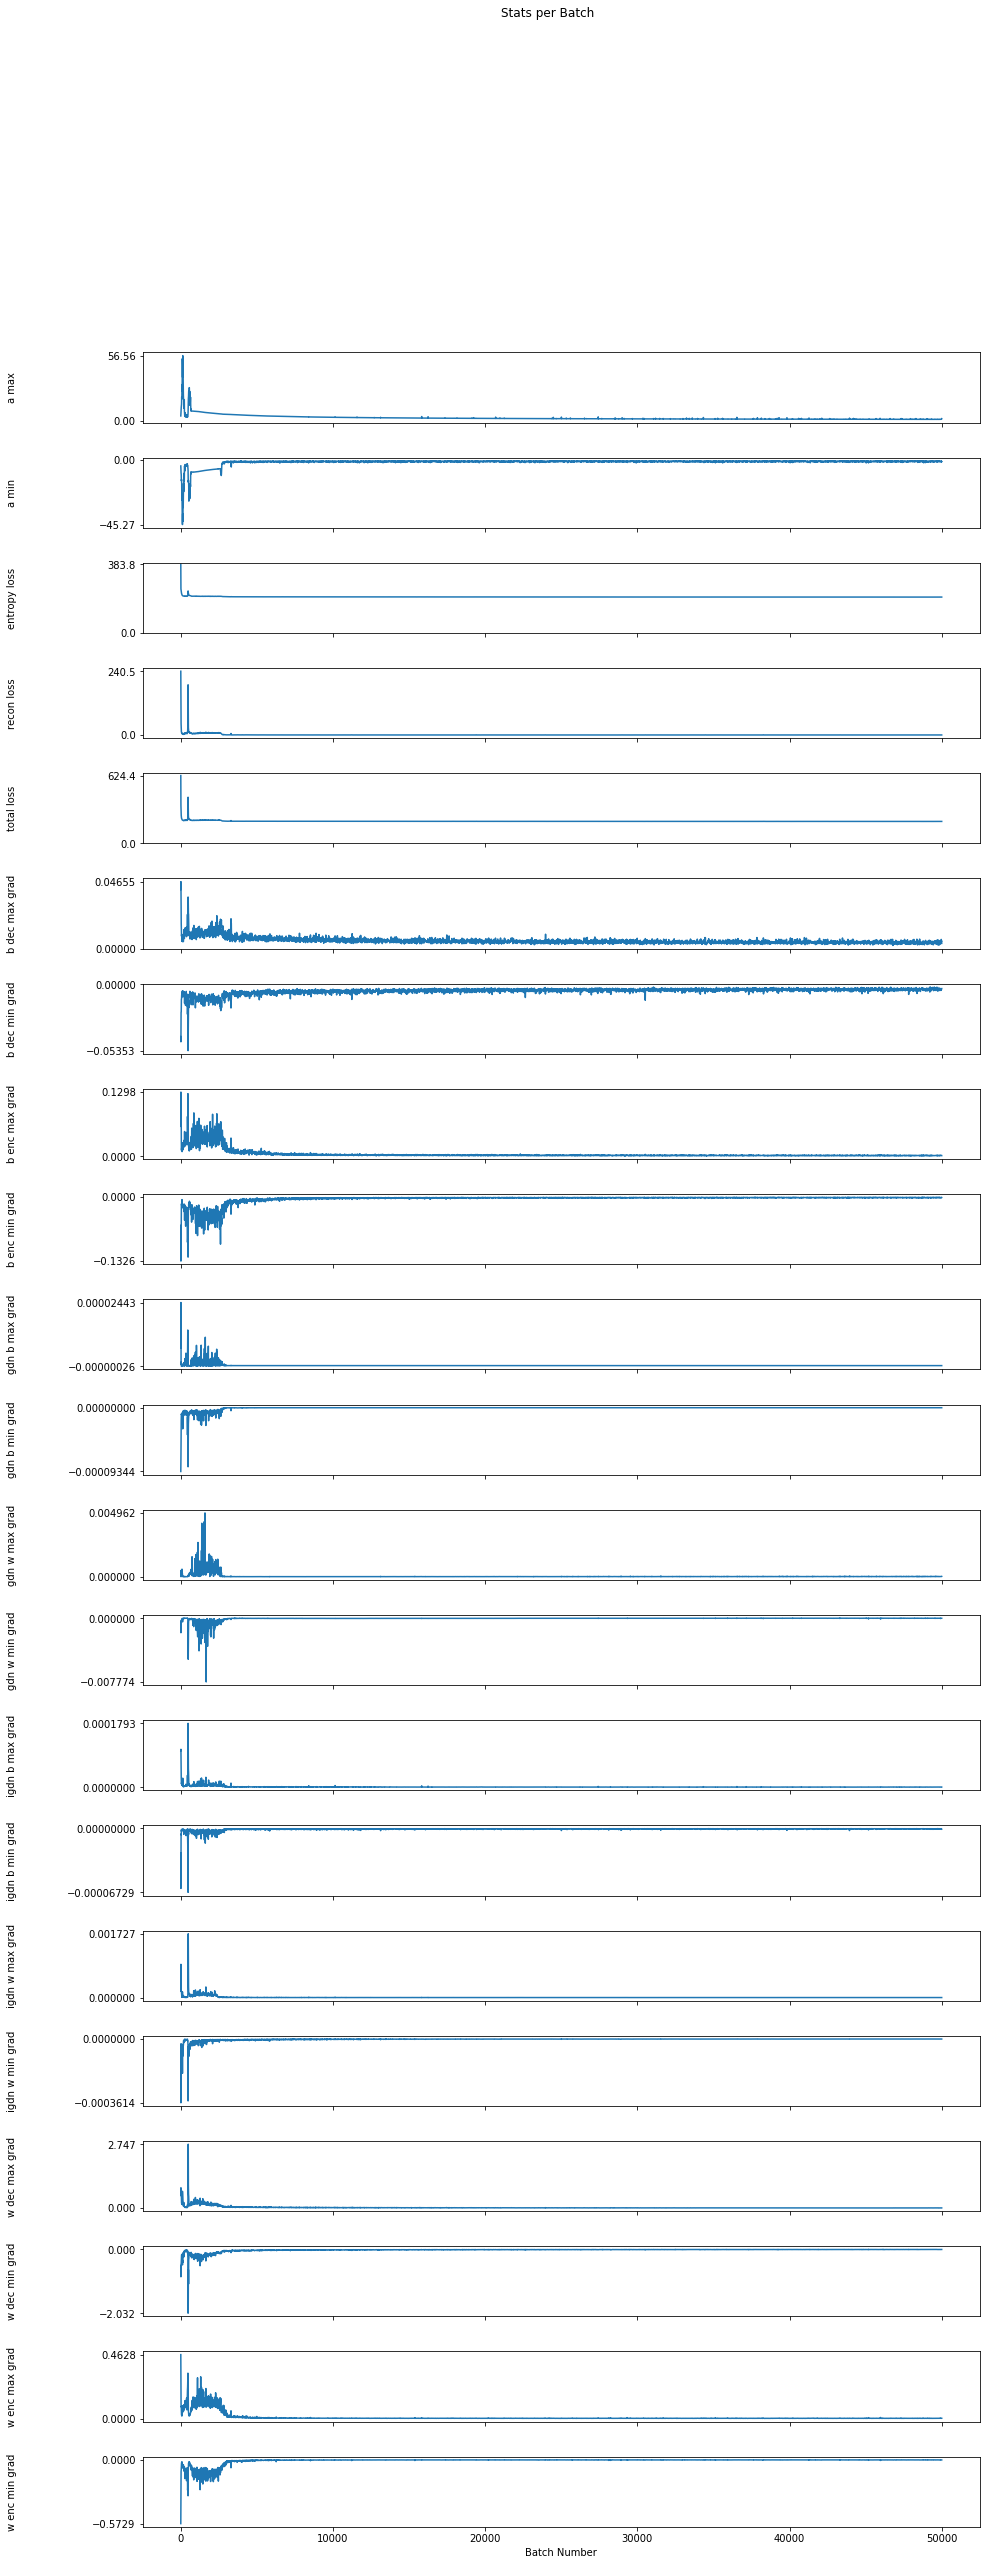

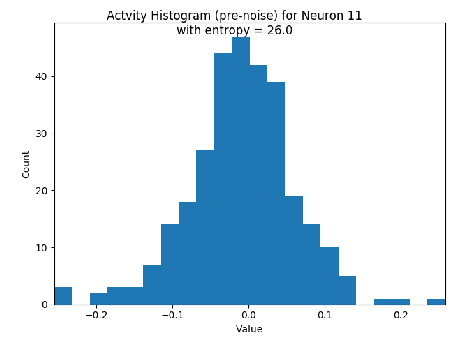

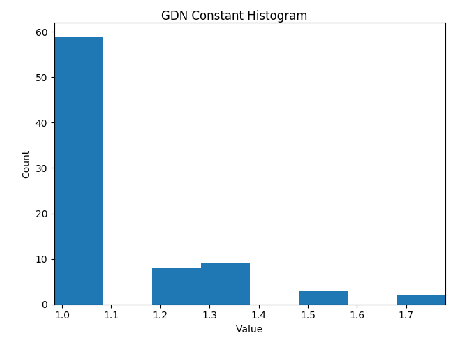

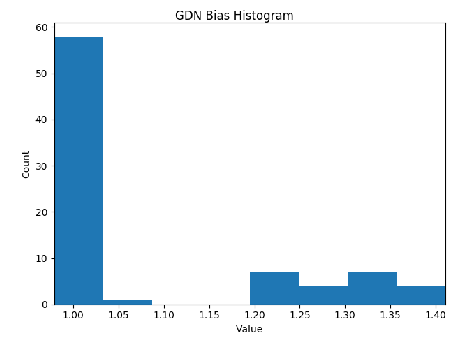

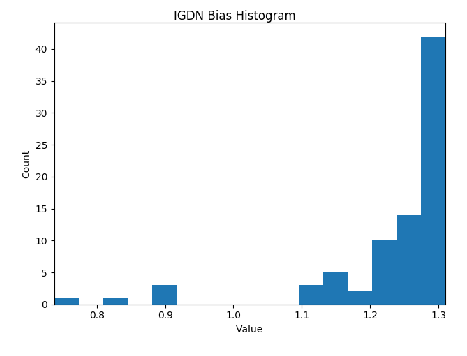

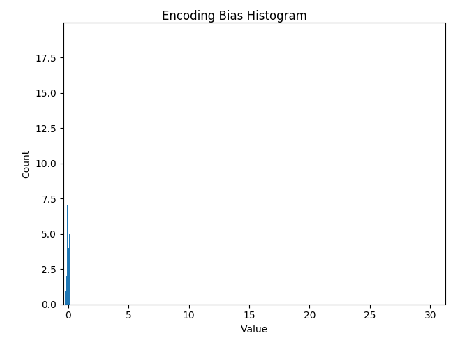

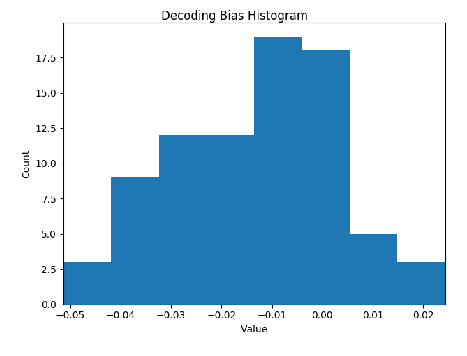

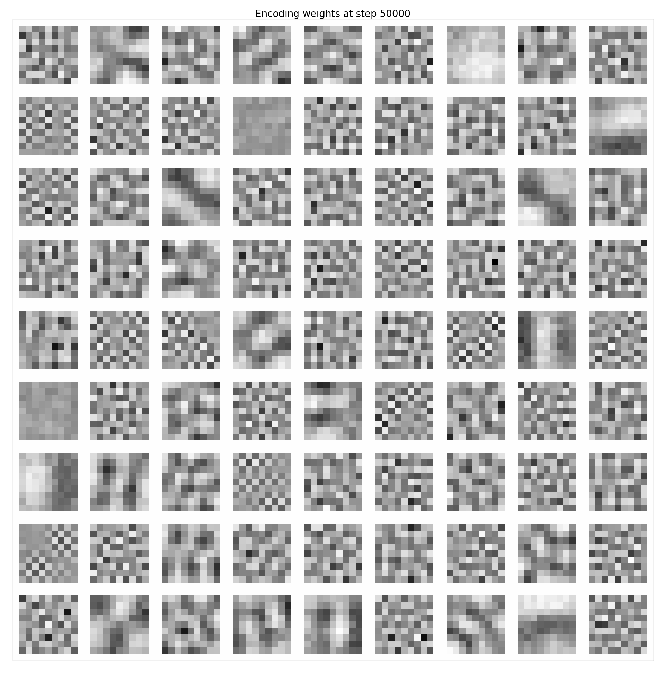

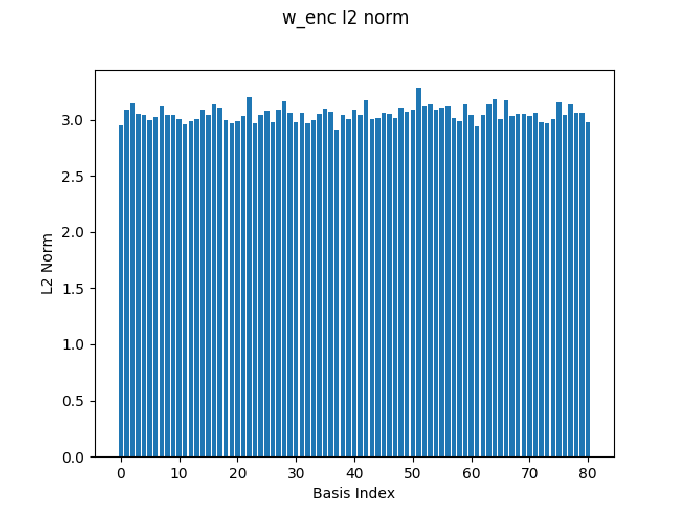

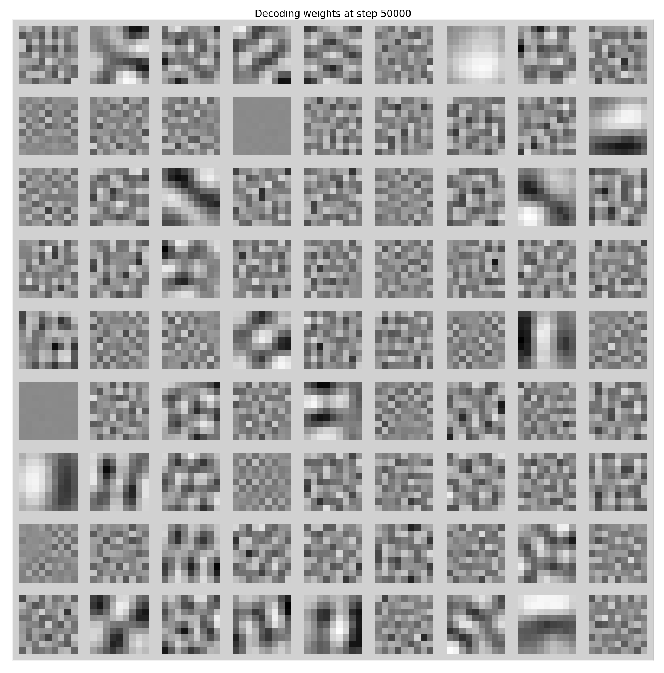

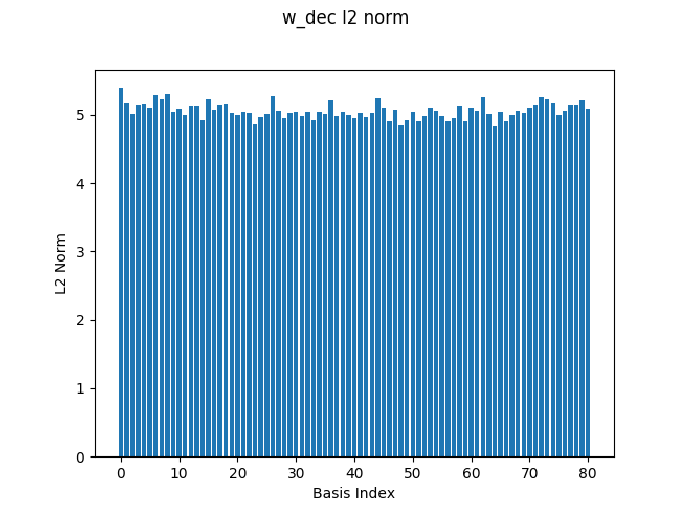

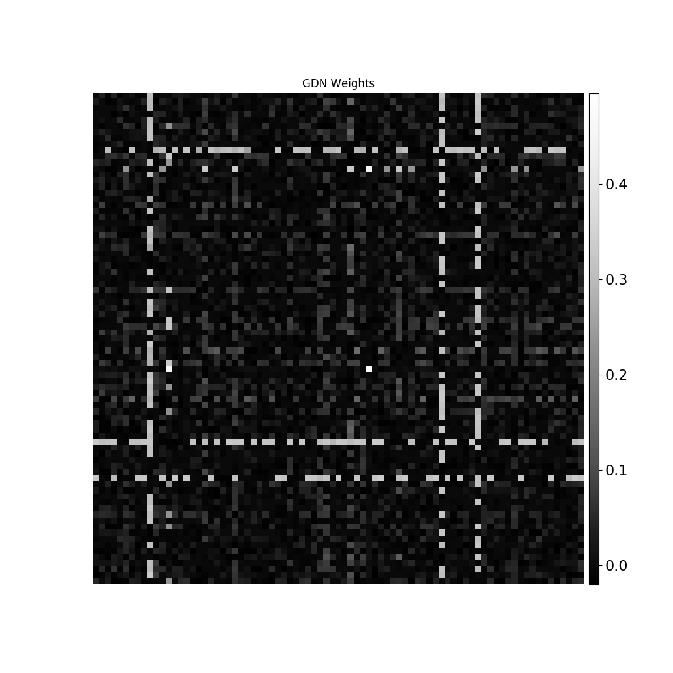

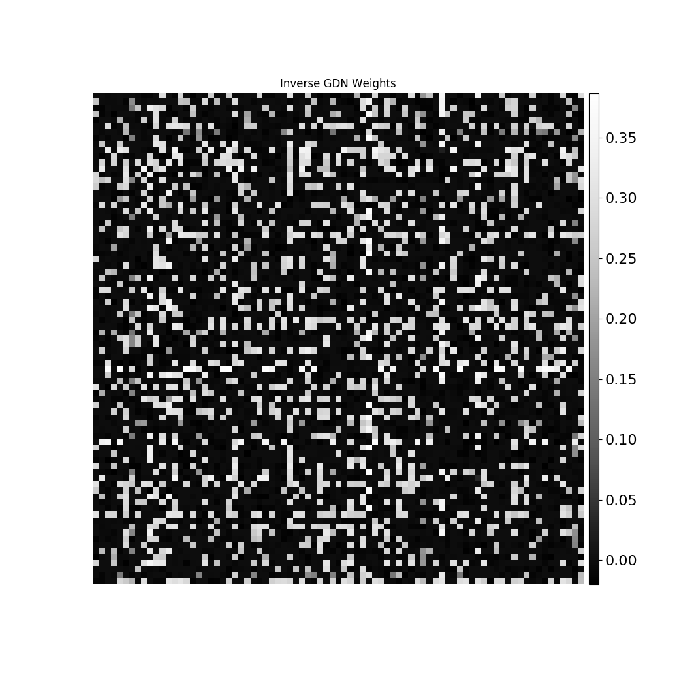

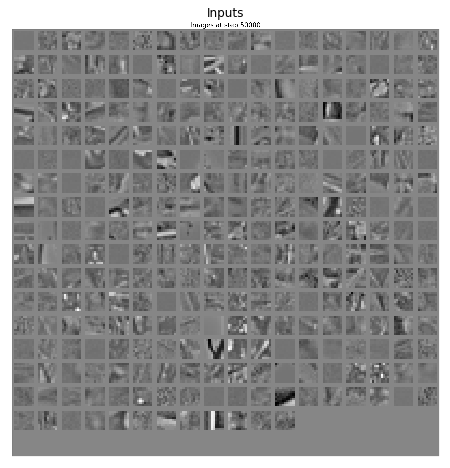

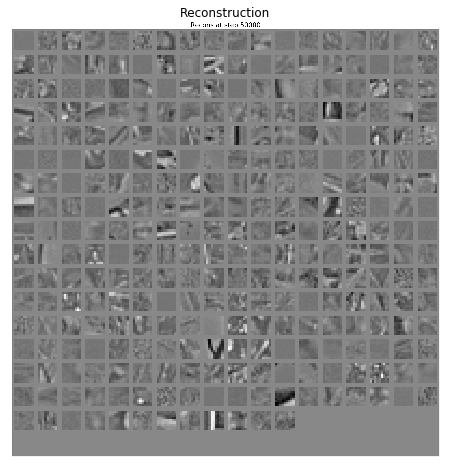

In [48]:
log_file = (params["model_dir"]+"/logfiles/"+params["model_name"]+"_v"+params["version"]+".log")
logger = Logger()
log_text = logger.load_file(log_file)
model_params = logger.read_params(log_text)
model_schedule = logger.read_schedule(log_text)

pp = pprint.PrettyPrinter(indent = 0)
print("---PARAMS---")
pp.pprint(model_params)
print("\n---SCHEDULE---")
pp.pprint(model_schedule)
print("------\n")

vis_dir = (model_params["out_dir"]+model_params["model_name"]+"/vis/")
vis_files = [file for file in os.listdir(vis_dir)]
indices = sorted([(mid, int(match.group(1)))
  for mid, match in
  enumerate([re.search("-(\d+)",filename) for filename in vis_files])
  if match], key=lambda x:x[1])
if len(vis_files) > 0:
  current_step = indices[-1][-1]
  prev_step = current_step
else:
  current_step = 0
  prev_step = 0
if current_step == prev_step:
  pass 
prev_step = current_step
print("Current step: ", current_step)
 
model_stats = logger.read_stats(log_text)

keys=["a_max",
  "a_min",
  "entropy_loss",
  "recon_loss",
  "total_loss",
  "b_dec_max_grad",
  "b_dec_min_grad",
  "b_enc_max_grad",
  "b_enc_min_grad",
  "gdn_b_max_grad",
  "gdn_b_min_grad",
  "gdn_w_max_grad",
  "gdn_w_min_grad",
  "igdn_b_max_grad",
  "igdn_b_min_grad",
  "igdn_w_max_grad",
  "igdn_w_min_grad",
  "w_dec_max_grad",
  "w_dec_min_grad",
  "w_enc_max_grad",
  "w_enc_min_grad"]
labels=["a max",
  "a min",
  "entropy loss",
  "recon loss",
  "total loss",
  "b dec max grad",
  "b dec min grad",
  "b enc max grad",
  "b enc min grad",
  "gdn b max grad",
  "gdn b min grad",
  "gdn w max grad",
  "gdn w min grad",
  "igdn b max grad",
  "igdn b min grad",
  "igdn w max grad",
  "igdn w min grad",
  "w dec max grad",
  "w dec min grad",
  "w enc max grad",
  "w enc min grad"]
stats_fig = pf.plot_stats(model_stats, keys=keys, labels=labels, figsize=(15,40))

#stats_fig = pf.plot_stats(model_stats, figsize=(15,40))

activity_details = "act_hist_v"+model_params["version"]
activity_files = [file for file in vis_files if activity_details in file]
if len(activity_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in activity_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+activity_files[indices[-1][0]]
  act_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(act_hist)
  ax = pf.clear_axis(ax)

gdn_const_details = "gdn_const_v"+model_params["version"]
gdn_const_files = [file for file in vis_files if gdn_const_details in file]
if len(gdn_const_files) > 0:
  disp_filename = vis_dir+gdn_const_files[0]
  gdn_const_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(gdn_const_hist)
  ax = pf.clear_axis(ax)

b_gdn_details = "b_gdn_hist_v"+model_params["version"]
b_gdn_files = [file for file in vis_files if b_gdn_details in file]
if len(b_gdn_files) > 0:
  disp_filename = vis_dir+b_gdn_files[0]
  b_gdn_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(b_gdn_hist)
  ax = pf.clear_axis(ax)

b_igdn_details = "b_igdn_hist_v"+model_params["version"]
b_igdn_files = [file for file in vis_files if b_igdn_details in file]
if len(b_igdn_files) > 0:
  disp_filename = vis_dir+b_igdn_files[0]
  b_igdn_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(b_igdn_hist)
  ax = pf.clear_axis(ax)

b_enc_details = "b_enc_hist_v"+model_params["version"]
b_enc_files = [file for file in vis_files if b_enc_details in file]
if len(b_enc_files) > 0:
  disp_filename = vis_dir+b_enc_files[0]
  b_enc_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(b_enc_hist)
  ax = pf.clear_axis(ax)

b_dec_details = "b_dec_hist_v"+model_params["version"]
b_dec_files = [file for file in vis_files if b_dec_details in file]
if len(b_dec_files) > 0:
  disp_filename = vis_dir+b_dec_files[0]
  b_dec_hist = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(b_dec_hist)
  ax = pf.clear_axis(ax)


def plot_weight_image(weight_details):
  weight_files = [file
    for file in vis_files
    if weight_details in file and "d"+w_name not in file]
  if len(weight_files) > 0:
    indices = sorted([(mid, int(match.group(1)))
      for mid, match in
      enumerate([re.search("-(\d+)",filename) for filename in weight_files])
      if match], key=lambda x:x[1])
    disp_filename = vis_dir+weight_files[indices[-1][0]]
    weights = scipy.ndimage.imread(disp_filename)
    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.imshow(weights)
    ax = pf.clear_axis(ax)

for w_name in params["weights"]:
  weight_details = w_name+"_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)
  weight_details = w_name+"_unnormalized_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)
  weight_details = w_name+"_norm_v"+model_params["version"]+"-"
  plot_weight_image(weight_details)

img_details = "images"
img_files = [file for file in vis_files if img_details in file]
if len(img_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in img_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+img_files[indices[-1][0]]
  recon = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(recon)
  ax = pf.clear_axis(ax)
  ax.set_title("Inputs")

recon_details = "recons_v"+model_params["version"]
recon_files = [file for file in vis_files if recon_details in file]
if len(recon_files) > 0:
  indices = sorted([(mid, int(match.group(1)))
    for mid, match in
    enumerate([re.search("-(\d+)",filename) for filename in recon_files])
    if match], key=lambda x:x[1])
  disp_filename = vis_dir+recon_files[indices[-1][0]]
  recon = scipy.ndimage.imread(disp_filename)
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.imshow(recon)
  ax = pf.clear_axis(ax)
  ax.set_title("Reconstruction")

plt.show()